In [1]:
!pip install pymorphy2
!wget -O pymorphy2-dicts-ru.tar.gz https://files.pythonhosted.org/packages/b2/b4/732ff6eeac8c9ea22e7e1c7a321b21b6f3ba19d5e0a8925f35da9c8ebbb2/pymorphy2-dicts-ru-2.4.404381.4453942.tar.gz

     |████████████████████████████████| 55 kB 807 kB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 2.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
--2024-04-21 07:37:03--  https://files.pythonhosted.org/packages/b2/b4/732ff6eeac8c9ea22e7e1c7a321b21b6f3ba19d5e0a8925f35da9c8ebbb2/pymorphy2-dicts-ru-2.4.404381.4453942.tar.gz
Resolving files.pythonhosted.org (files.pythonhosted.org)... 199.232.96.223, 2a04:4e42:2000::223, 2a04:4e42:3000::223, ...
Connecting to files.pythonhosted.org (files.pythonhosted.org)|199.232.96.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7934073 (7.6M) [binary/octet-stream]
Saving to: ‘pymorphy2-dicts-ru.tar.gz’

pymorphy2-dicts-ru. 100%[===================>]   7.57M  22.7MB/s    in 0.3s    

2024-04-21 07:37:04 (22.7 MB/s) - ‘pymorphy2-dicts-ru.tar.gz’ saved [7934073/7934073]



In [2]:
! pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=af9450c5ba6bf6f7cd1552b4113ac16be5bce05b1ada13cb736f1f95bc4a8094
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import pickle

import tarfile
from tqdm import tqdm_notebook as tqdm

from multiprocessing import Pool

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('russian')

from string import punctuation
punkt= [p for p in punctuation] + ["`", "``" ,"''", "'"]

import gensim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fasttext
import pymorphy2

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
rudict = tarfile.open('./pymorphy2-dicts-ru.tar.gz')
rudict.extractall()
rudict.close()

In [5]:
lemmatizer = pymorphy2.MorphAnalyzer(path='./pymorphy2-dicts-ru-2.4.404381.4453942/pymorphy2_dicts_ru/data',lang='ru')

In [6]:
data = pd.read_csv('../input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
data.date = pd.to_datetime(data.date)

In [8]:
tags_to_use = data.tags.value_counts()[data.tags.value_counts() > 500].index

In [9]:
data = data[data.tags.isin(tags_to_use)]

In [10]:
data = data[data['tags'] != 'Деловой климат']
data = data[data['tags'] != 'Все']
data = data[data['tags'] != 'Рынки']
data = data[data['tags'] != 'Оружие']
data = data[data['tags'] != 'Мемы']
data = data[data['tags'] != 'Вирусные ролики']
data = data[data['tags'] != 'Движение']
data = data[data['tags'] != 'Офис']
data = data[data['tags'] != 'Инструменты']
data = data[data['tags'] != 'Часы']
data = data[data['tags'] != 'История']
data = data[data['tags'] != 'Жизнь']
data = data[data['tags'] != 'Достижения']
data = data[data['tags'] != 'Деньги']

In [11]:
data.loc[data['tags'].str.contains('ТВ и радио', case=False), 'tags'] = 'Телевидение'
data.loc[data['tags'].str.contains('Люди', case=False), 'tags'] = 'Персоны'
data.loc[data['tags'].str.contains('Мнения', case=False), 'tags'] = 'Персоны'
data.loc[data['tags'].str.contains('Происшествия', case=False), 'tags'] = 'События'
data.loc[data['tags'].str.contains('Конфликты', case=False), 'tags'] = 'События'
data.loc[data['tags'].str.contains('Явления', case=False), 'tags'] = 'События'
data.loc[data['tags'].str.contains('Госэкономика', case=False), 'tags'] = 'Экономика'
data.loc[data['tags'].str.contains('Следствие и суд', case=False), 'tags'] = 'Закон и право'
data.loc[data['tags'].str.contains('Квартира', case=False), 'tags'] = 'Дом'
data.loc[data['tags'].str.contains('Космос', case=False), 'tags'] = 'Наука'
data.loc[data['tags'].str.contains('Coцсети', case=False), 'tags'] = 'Интернет'
data.loc[data['tags'].str.contains('Криминал', case=False), 'tags'] = 'Преступность'
data.loc[data['tags'].str.contains('Стиль', case=False), 'tags'] = 'Мода'
data.loc[data['tags'].str.contains('Бокс и ММА', case=False), 'tags'] = 'Спорт'
data.loc[data['tags'].str.contains('Закавказье', case=False), 'tags'] = 'Мир'
data.loc[data['tags'].str.contains('Прибалтика', case=False), 'tags'] = 'Мир'
data.loc[data['tags'].str.contains('Белоруссия', case=False), 'tags'] = 'Мир'
data.loc[data['tags'].str.contains('Средняя Азия', case=False), 'tags'] = 'Мир'
data.loc[data['tags'].str.contains('Молдавия', case=False), 'tags'] = 'Мир'
data.loc[data['tags'].str.contains('Театр', case=False), 'tags'] = 'Искусство'
data.loc[data['tags'].str.contains('Техника', case=False), 'tags'] = 'Технологии'
data.loc[data['tags'].str.contains('Дача', case=False), 'tags'] = 'Дом'
data.loc[data['tags'].str.contains('Книги', case=False), 'tags'] = 'Искусство'
data.loc[data['tags'].str.contains('Внешний вид', case=False), 'tags'] = 'Красота'
data.loc[data['tags'].str.contains('Москва', case=False), 'tags'] = 'Россия'
data.loc[data['tags'].str.contains('Футбол', case=False), 'tags'] = 'Спорт'
data.loc[data['tags'].str.contains('Хоккей', case=False), 'tags'] = 'Спорт'
data.loc[data['tags'].str.contains('Мировой бизнес', case=False), 'tags'] = 'Бизнес'
data.loc[data['tags'].str.contains('Софт', case=False), 'tags'] = 'Технологии'
data.loc[data['tags'].str.contains('Звери', case=False), 'tags'] = 'Животные'
data.loc[data['tags'].str.contains('Регионы', case=False), 'tags'] = 'Россия'

In [12]:
data.tags.value_counts(normalize=True)

Политика                0.135807
Общество                0.117416
События                 0.101742
Украина                 0.075125
Спорт                   0.067130
Экономика               0.054278
Интернет                0.043208
Наука                   0.040836
Кино                    0.035756
Бизнес                  0.033355
Закон и право           0.030463
Мир                     0.029786
Преступность            0.027571
Персоны                 0.024749
Музыка                  0.024703
Дом                     0.021601
Россия                  0.019589
Искусство               0.015433
Телевидение             0.014646
Летние виды             0.010890
Животные                0.010217
Мода                    0.008559
Город                   0.007938
Полиция и спецслужбы    0.007925
Гаджеты                 0.007842
Зимние виды             0.007648
Игры                    0.006984
Пресса                  0.006831
Технологии              0.006731
Красота                 0.003492
Еда       

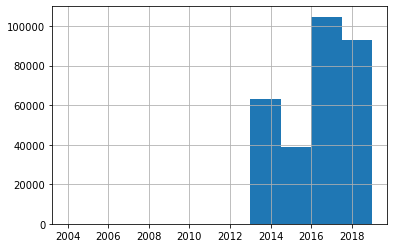

In [13]:
data.date.dt.year.hist()

In [14]:
data.head(10)

,url,title,text,topic,tags,date
93088,https://lenta.ru/world/2004/05/12/estonia/,Эстония согласна простить Россию в обмен на Но...,"Россия могла бы компенсировать Эстонии ущерб, ...",Бывший СССР,Мир,2004-05-12
226891,https://lenta.ru/news/2008/04/25/snipes/,Уэсли Снайпса приговорили к трем годам тюрьмы,Американского актера Уэсли Снайпса в четверг п...,Культура,Кино,2008-04-25
275318,https://lenta.ru/news/2009/03/25/arrest2/,В убийстве американского радиоведущего признал...,В Нью-Йорке арестован подозреваемый в убийстве...,Мир,Преступность,2009-03-25
307184,https://lenta.ru/news/2009/11/13/birth/,Сеульские власти повысят рождаемость путем орг...,Власти одного из районов столицы Южной Кореи з...,Мир,Общество,2009-11-13
354376,https://lenta.ru/news/2010/11/27/plot/,Выходец из Сомали планировал теракт в Портленде,В городе Портленд штата Орегон вечером 26 нояб...,Мир,Преступность,2010-11-27
377604,https://lenta.ru/news/2011/06/08/killerbear/,Канадских автомобилистов убило сбитым на дорог...,На трассе в Канаде произошло ДТП с участием ме...,Мир,События,2011-06-08
412194,https://lenta.ru/news/2012/03/13/bigmuseum/,Заложен первый камень Великого Египетского музея,"В понедельник, 12 марта, начался третий этап с...",Культура,Искусство,2012-03-13
421323,https://lenta.ru/news/2012/05/23/travelwithcar/,РЖД разрешит пассажирам путешествовать с автом...,"""Федеральная пассажирская компания"", входящая ...",Экономика,Бизнес,2012-05-23
434341,https://lenta.ru/news/2012/09/07/transit/,В России появятся электрические маршрутки,"Компания ""Револьта"" получила разрешение на имп...",Наука и техника,Технологии,2012-09-07
444694,https://lenta.ru/news/2012/11/27/poezd/,РЖД впервые перевезла пассажиров с личными авт...,Вечером 26 ноября 2012 года из Москвы в Хельси...,Экономика,Бизнес,2012-11-27


In [15]:
data.size

1798842

In [16]:
data[data.tags.isna()]

,url,title,text,topic,tags,date


In [17]:
news_title = data['title']
news_text = data['text']
news_tags = data['tags']

In [18]:
def tokenize(sent):
    try:
        sent = word_tokenize(sent)
        return [word for word in sent if word not in stop and word not in punkt]
    except:
        return []
    
def lemmatize(sent):
    try:
        return " ".join([lemmatizer.normal_forms(word)[0] for word in sent])
    except:
        return " "

def preprocess_sent(sent):
    return lemmatize(tokenize(sent))

In [19]:
s = news_text[:100].tolist()

In [20]:
preprocess_sent(s[0])

'россия мочь компенсировать эстония ущерб нанести год советский оккупация отдать постоянный пользование новосибирский область такой заявление сделать председатель специальный государственный комиссия расследование репрессивный политика профессор торонтский университет велло сало как сообщаться сайт газета газета течение 12 год комиссия заниматься подсчёт размер ущерб нанести эстония гитлеровский германия советский союз период 1940 1991 год 10 май комиссия представить результат свой работа мы представить отчёт ущерб нанести эстония год советский власть вследствие оккупация германия но период немецкий оккупация сравнительно недолгий основный внимание уделить советский период – заявить велло сало согласно материал исследование результат советский оккупация эстония потерять 180 тысяча человек составлять 18 процент население жизнь каждый эстонец комиссия оценить 1 миллион крона 75 тысяча доллар именно столько считать сало деньга приносить государство среднее гражданин течение жизнь однако в

In [21]:
with Pool(8) as p:
    titles_preprocessed = list(tqdm(
                                    p.imap(preprocess_sent, news_title.tolist()),
                                    total=news_title.size
                                    )
                             )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [22]:
# with open('titles_preprocessed.pkl', 'wb') as write_titles:
#     pickle.dump(titles_preprocessed, write_titles)

In [23]:
y = news_tags.tolist()

In [24]:
title_train, title_test, y_train, y_test = train_test_split(titles_preprocessed, y, test_size=0.25, stratify=y, random_state=42)

In [25]:
with open('train_data_titles.txt', 'w+', encoding='utf-8') as tr:
    for idx in range(len(title_train)):
        tr.write('__label__' + y_train[idx] + ' ' + title_train[idx] + '\n')
        
with open('test_data_titles.txt', 'w+', encoding='utf-8') as te:
    for idx in range(len(title_test)):
        te.write('__label__' + y_test[idx] + ' ' + title_test[idx] + '\n')        

In [26]:
%%time
ft_model = fasttext.train_supervised(input='train_data_titles.txt')

CPU times: user 16.6 s, sys: 74 ms, total: 16.7 s
Wall time: 5.98 s


In [27]:
ft_model.predict(preprocess_sent('Кремль обеспокоен: висит груша, нельзя скушать'), k=3)

(('__label__Политика', '__label__Общество', '__label__Экономика'),
 array([0.97457349, 0.01001756, 0.00623938]))

In [28]:
ft_model.predict(preprocess_sent(input()), k=3)

 Аааааа убили негра


(('__label__Общество', '__label__Преступность', '__label__События'),
 array([0.45404857, 0.30929562, 0.22887433]))

In [29]:
from sklearn.metrics import f1_score

In [30]:
good = 0
total = 0
for i in range(0, 1000):
    good += (y_test[i] in [x.split('__')[2] for x in ft_model.predict(preprocess_sent(title_test[i]), k=3)[0]])
    total += 1

In [31]:
acc = good / total
acc

0.848

In [32]:
true_positives = 0
false_positives = 0
false_negatives = 0

for i in range(0, 1000):
    predicted_labels = [x.split('__')[2] for x in ft_model.predict(preprocess_sent(title_test[i]), k=3)[0]]
    true_label = y_test[i]
    if true_label in predicted_labels:
        true_positives += 1
    else:
        if any(true_label in x for x in predicted_labels):
            false_negatives += 1
        else:
            false_positives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

f1_score

0.9177489177489178

In [33]:
ft_model.save_model('FINAL_MODEL_CLASSIFICATION.bin')

In [43]:
model = fasttext.load_model('/kaggle/working/FINAL_MODEL_CLASSIFICATION.bin')

def get_tag(text):
    result = model.predict(preprocess_sent(text), k=1)[0][0].split('__')[2]
    return result

In [75]:
ft_model.save_model('optimized.model')

In [54]:
get_tag(input())

 Ученые рассказали, что за вирус вызовет следующую пандемию  Новую пандемию в ближайшем будущем вызовет вирус гриппа, предупреждают ученые, пишет The Guardian. 57% опрошенных ученых из нового международного исследования считают, что наиболее вероятной причиной новой пандемии станет вирус гриппа. Еще 21% полагает, что новая вспышка произойдет из-за «болезни X».


'Наука'

In [34]:
titles_for_w2v = [sent.split(" ") for sent in titles_preprocessed]

In [35]:
%%time
from gensim.models import Word2Vec
w2v = Word2Vec(sentences=titles_for_w2v, min_count=3, size=50, window=6, seed=33, workers=4)

CPU times: user 48.1 s, sys: 108 ms, total: 48.2 s
Wall time: 26.9 s


In [36]:
w2v.save('FINAL_MODEL_SIMILAR.bin.gz')

In [37]:
w2v = Word2Vec.load('FINAL_MODEL_SIMILAR.bin.gz')
type(w2v)

gensim.models.word2vec.Word2Vec

In [38]:
w2v_vectors = w2v.wv

In [39]:
w2v_vectors['инвестиция']

array([-5.6456441e-01,  1.4280484e+00, -2.1502243e-01,  4.5403355e-01,
        1.6280344e-01,  4.6431121e-01,  2.2094268e-01, -7.3497957e-01,
       -8.8543728e-02,  1.4667749e+00, -7.9431736e-01, -1.6860636e-01,
        1.9005089e-01,  6.0659671e-01,  6.6151196e-01, -5.3386909e-01,
        3.0692932e-01, -6.2416887e-01,  1.3165032e+00,  5.6570584e-01,
       -1.1155959e+00,  4.2989436e-01,  2.0964544e-01,  4.2976320e-02,
        6.4009356e-01, -7.5867766e-01, -3.2412905e-01, -1.0413561e+00,
       -5.0503761e-01, -2.4993090e-01, -6.0446471e-01,  9.4916448e-02,
        6.5977800e-01, -5.7800603e-01, -2.5726092e-01, -5.1887184e-01,
        4.8259694e-02,  1.2902088e+00, -1.6029632e+00,  9.4257730e-01,
       -2.9736662e-01, -2.9916671e-04, -1.2742108e-01,  9.9128228e-01,
       -6.6654205e-02,  1.7048107e+00, -9.9354583e-01,  1.0545746e+00,
        5.4878569e-01,  2.3005991e-01], dtype=float32)

In [40]:
w2v.most_similar('инвестиция')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('облигация', 0.9341613054275513),
 ('резерв', 0.9150769710540771),
 ('капитал', 0.9014952182769775),
 ('валюта', 0.896378755569458),
 ('бюджет', 0.8910320997238159),
 ('объём', 0.8857218027114868),
 ('промышленность', 0.8843151330947876),
 ('стабильный', 0.8810085654258728),
 ('экспортёр', 0.8809418082237244),
 ('кредит', 0.8754545450210571)]

In [41]:
w2v.most_similar('моисеев')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'моисеев' not in vocabulary"

In [ ]:
w2v.most_similar(positive=['чиновник'], negative=['взяточничество'])

In [ ]:
w2v.most_similar('наука')

In [ ]:
! pip install natasha